# A Re-Sampling Approach

In [2]:
library(ISLR2)

Here, we implement the re-sampling approach to hypothesis testing using the `Khan` dataset, which we investigated in Section 13.5. First, we merge the training and testing data, which results in observations on 83 patients for 2,308 genes.

In [5]:
attach(Khan)
x <- rbind(xtrain, xtest)
y <- c(as.numeric(ytrain), as.numeric(ytest))
dim(x)
table(y)

The following objects are masked from Khan (pos = 3):

    xtest, xtrain, ytest, ytrain


The following objects are masked from Khan (pos = 4):

    xtest, xtrain, ytest, ytrain




[1]   83 2308

y
 1  2  3  4 
11 29 18 25 

There are four classes of cancer. For each gene, we compare the mean expression in the second class (rhabdomyosarcoma) to the mean expression in the fourth class (Burkitt's lymphoma). Performing a standard two-sample t-test on the 11th gene produces a test-statistic of $-2.09$ and an associated p-value of $0.0412$, suggesting modest evidence of a difference in mean expression levels between the two cancer types.

In [6]:
x <- as.matrix(x)
x1 <- x[which(y == 2),]
x2 <- x[which(y == 4),]
n1 <- nrow(x1)
n2 <- nrow(x2)
t.out <- t.test(x1[, 11], x2[, 11], var.equal = TRUE)
TT <- t.out$statistic
TT
t.out$p.value

t 
-2.093633

[1] 0.04118644

However, this p-value relies on the assumption that under the null hypothesis of no difference between the two groups, the test statistic follows a t-distribution with $29 + 25 - 2 = 52$ degrees of freedom. Instead of using this theoretical null distribution, we can randomly split the 54 patients into two groups of 29 and 25, and compute a new test statistic. Under the null hypothesis of no difference between the groups, this new test statistic should have the same distribution as our original one. Repeating this process 10,000 times allows us to approximate the null distribution of the test statistic. We compute the fraction of the time that our observed test statistic exceeds the test statistics obtained via re-sampling.

In [7]:
set.seed(1)
B <- 10000
Tbs <- rep(NA, B)
for (b in 1:B) {
    dat <- sample(c(x1[, 11], x2[, 11]))
    Tbs[b] <- t.test(dat[1:n1], dat[(n1 + 1):(n1 + n2)],
        var.equal = TRUE)$statistic
}
mean((abs(Tbs) >= abs(TT)))

[1] 0.0416

This fraction, $0.0416$, is our re-sampling-based p-value. It is almost identical to the p-value of $0.0412$ obtained using the theoretical null distribution.

We can plot a histogram of the re-sampling-based test statistics in order to reproduce Figure 13.7.

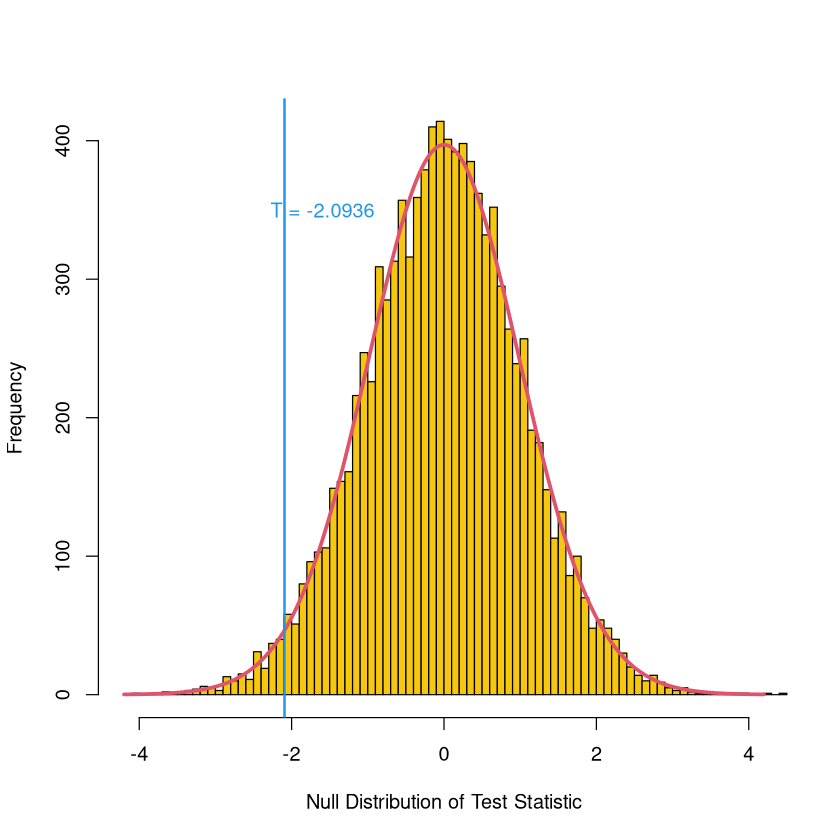

In [8]:
hist(Tbs, breaks = 100, xlim = c(-4.2, 4.2), main = "",
     xlab = "Null Distribution of Test Statistic", col = 7)
lines(seq(-4.2, 4.2, len = 1000),
    dt(seq(-4.2, 4.2, len = 1000),
        df = (n1 + n2 - 2)) * 1000, col = 2, lwd = 3)
abline(v = TT, col = 4, lwd = 2)
text(TT + 0.5, 350, paste("T = ", round(TT, 4), sep = ""), col = 4)

The re-sampling-based null distribution is almost identical to the theoretical null distribution, which is displayed in red.

Finally, we implement the plug-in re-sampling FDR approach outlined in Algorithm 13.4. Depending on the speed of your computer, calculating the FDR for all 2,308 genes in the `Khan` dataset may take a while. Hence, we will illustrate the approach on a random subset of 100 genes. For each gene, we first compute the observed test statistic, and then produce 10,000 re-sampled test statistics. This may take a few minutes to run. If youa re in a rush, then you could set `B` equal to a smaller value (e.g. `B = 500`).

In [9]:
m <- 100
set.seed(1)
index <- sample(ncol(x1), m)
Ts <- rep(NA, m)
Ts.star <- matrix(NA, ncol = m, nrow = B)
for (j in 1:m) {
    k <- index[j]
    Ts[j] <- t.test(x1[, k], x2[, k],
        var.equal = TRUE)$statistic
    for (b in 1:B) {
        dat <- sample(c(x1[, k], x2[, k]))
        Ts.star[b, j] <- t.test(dat[1:n1],
            dat[(n1 + 1):(n1 + n2)], var.equal = TRUE)$statistic
    }
}

Next, we compute the number of rejected null hypotheses $R$, the estimated number of false positives $\hat{V}$, and the estimated FDR, for a range of threshold values $c$ in Algorithm 13.4. The threshold values are chosen using the absolute values of the test statistics from the 100 genes.

In [10]:
cs <- sort(abs(Ts))
FDRs <- Rs <- Vs <- rep(NA, m)
for (j in 1:m) {
    R <- sum(abs(Ts) >= cs[j])
    V <- sum(abs(Ts.star) >= cs[j]) / B
    Rs[j] <- R
    Vs[j] <- V
    FDRs[j] <- V / R
}

Now, for any given FDR, we can find the genes that will be rejected. For example, with the FDR controlled at $0.1$, we reject 15 of the 100 null hypotheses. On average, we would expect about one or two of these genes (i.e. $10\%$ of 15) to be false discoveries. At an FDR of $0.2$, we can reject the null hypothesis for 28 genes, of which we expect around six to be false discoveries. The variable `index` is needed here since we restricted our analysis to just 100 randomly-selected genes.

In [11]:
max(Rs[FDRs <= .1])
sort(index[abs(Ts) >= min(cs[FDRs < .1])])
max(Rs[FDRs <= .2])
sort(index[abs(Ts) >= min(cs[FDRs < .2])])

[1] 15

[1]   29  465  501  554  573  729  733 1301 1317 1640 1646 1706 1799 1942 2159

[1] 28

[1]   29   40  287  361  369  465  501  554  573  679  729  733  990 1069 1073
[16] 1301 1317 1414 1639 1640 1646 1706 1799 1826 1942 1974 2087 2159

The next line generates Figure 13.11, which is similar to Figure 13.9, except that it is based on only a subset of the genes.

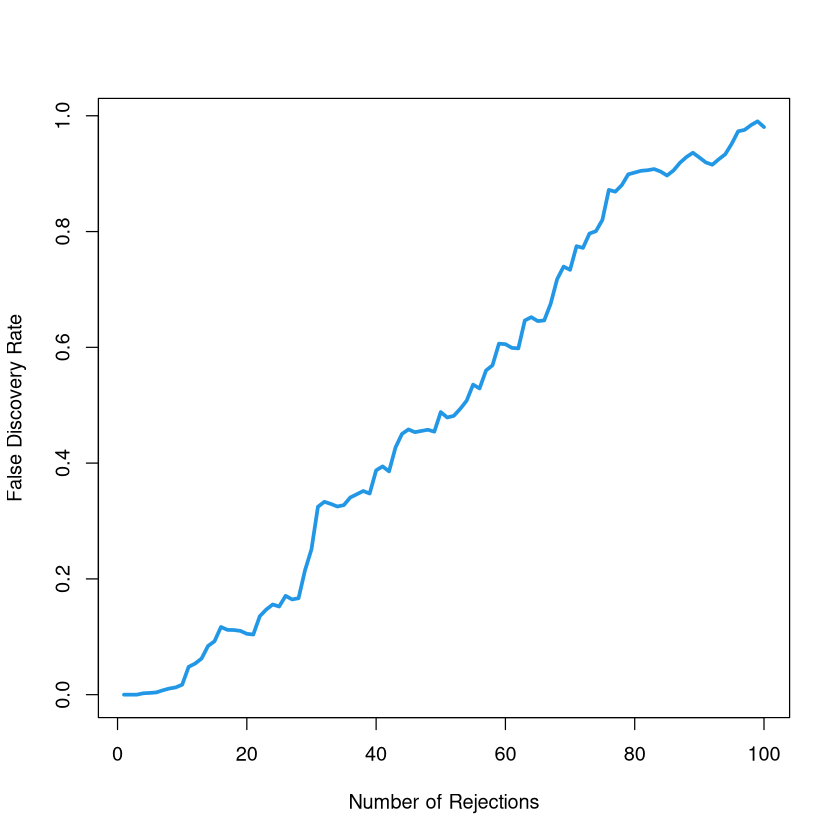

In [12]:
plot(Rs, FDRs, xlab = "Number of Rejections", type = "l", ylab = "False Discovery Rate", col = 4, lwd = 3)

As noted in the chapter, much more efficient implementations of the re-sampling approach to FDR calculation are available, using e.g. the `samr` package in `R`.